In [1]:
# THIS IS THE SETUP CODE
from google.colab import drive
import os

# 1. Mount Google Drive (It will ask for permission)
drive.mount('/content/drive')

# 2. Move to your project folder
# This tells Python: "Work inside the fraud_detection_project folder"
# MAKE SURE THIS PATH MATCHES YOUR FOLDER NAME EXACTLY
project_path = '/content/drive/MyDrive/fraud_detection_project'

try:
    os.chdir(project_path)
    print("SUCCESS: Connected to your Project Folder!")
    print("Here are the files I can see:")
    print(os.listdir('data')) # This checks inside your data folder
except:
    print("ERROR: Could not find the folder. Check your folder name in Google Drive.")

Mounted at /content/drive
SUCCESS: Connected to your Project Folder!
Here are the files I can see:
['Train-1542865627584.csv', 'Train_Beneficiarydata-1542865627584.csv', 'Train_Outpatientdata-1542865627584.csv', 'Train_Inpatientdata-1542865627584.csv', 'provider_level_dataset.csv', 'final_logistic_regression_model.joblib']


In [2]:
# --- IMPORT LIBRARIES ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

# --- LOAD DATA ---
# Adjust path if necessary
file_path = 'data/provider_level_dataset.csv'
df = pd.read_csv(file_path)

print(f"Dataset Loaded. Shape: {df.shape}")
df.head()

Dataset Loaded. Shape: (5410, 25)


,Provider,NumClaims,NumUniqueBeneficiaries,TotalReimbursed,AvgClaimAmount,AvgClaimDuration,AvgHospitalDuration,AvgAge,AdmissionRate,NumInpatientClaims,...,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,InpatientShare,OutpatientShare
0,PRV51001,25,24,104640,4185.600000,2.440000,1.000000,77.880000,0.200000,5,...,1.800000,1.600000,1.640000,1.160000,1.080000,1.760000,1.680000,1.760000,0.200000,0.800000
1,PRV51003,132,117,605670,4588.409091,4.674242,2.424242,69.106061,0.469697,62,...,1.924242,1.689394,1.590909,1.242424,1.151515,1.750000,1.712121,1.909091,0.469697,0.530303
2,PRV51004,149,138,52170,350.134228,2.429530,0.000000,71.302013,0.000000,0,...,1.892617,1.724832,1.577181,1.295302,1.275168,1.671141,1.691275,1.885906,0.000000,1.000000
3,PRV51005,1165,495,280910,241.124464,2.088412,0.000000,69.567382,0.000000,0,...,1.858369,1.746781,1.583691,1.314163,1.231760,1.704721,1.715880,1.893562,0.000000,1.000000
4,PRV51007,72,58,33710,468.194444,1.958333,0.222222,68.375000,0.041667,3,...,1.833333,1.777778,1.597222,1.319444,1.291667,1.708333,1.694444,1.833333,0.041667,0.958333


In [3]:
# --- PREPARE FEATURES (X) AND TARGET (y) ---

# 1. Define Target
# Ensure it's 0/1 (It should be from Notebook 1, but good to check)
if df['PotentialFraud'].dtype == 'object':
    y = df['PotentialFraud'].map({'Yes': 1, 'No': 0})
else:
    y = df['PotentialFraud']

# 2. Define Features
# Drop ID (Provider) and Target (PotentialFraud)
X = df.drop(columns=['Provider', 'PotentialFraud'])

print(f"Features (X) Shape: {X.shape}")
print(f"Target (y) Distribution: {Counter(y)}")

Features (X) Shape: (5410, 23)
Target (y) Distribution: Counter({0: 4904, 1: 506})


In [4]:
# --- TRAIN/TEST SPLIT ---

# Stratify=y ensures the Test set has the same 10% fraud ratio as the real world
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Data Split Successfully:")
print(f"Training Set: {X_train.shape[0]} providers")
print(f"Test Set:     {X_test.shape[0]} providers")

Data Split Successfully:
Training Set: 4328 providers
Test Set:     1082 providers


In [12]:
# --- APPLY SMOTE (Oversampling) ---

print("Original Training Counts:", Counter(y_train))

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit and resample ONLY the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Resampled Training Counts:", Counter(y_train_resampled))
print("\n(Notice: Fraud and Non-Fraud counts are now equal in the training set)")

Original Training Counts: Counter({0: 3923, 1: 405})
Resampled Training Counts: Counter({0: 3923, 1: 3923})

(Notice: Fraud and Non-Fraud counts are now equal in the training set)


In [13]:
# --- STEP 5: METRICS & EVALUATION FUNCTION ---
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    classification_report
)

def evaluate_model(model, X_test, y_test, model_name="Model"):
    """
    Evaluates a trained model on the test set and prints key metrics.
    Prioritizes Precision, Recall, F1, and PR-AUC over Accuracy.
    """
    # 1. Make Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Probability of Fraud (Class 1)

    # 2. Calculate Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)

    # 3. Print Results
    print(f"--- {model_name} Performance ---")
    print(f"Accuracy:      {acc:.4f} (Misleading for imbalanced data)")
    print(f"Precision:     {prec:.4f}")
    print(f"Recall:        {rec:.4f}  <-- CRITICAL")
    print(f"F1-Score:      {f1:.4f}")
    print(f"ROC-AUC:       {roc_auc:.4f}")
    print(f"PR-AUC:        {pr_auc:.4f} (Best for imbalance)")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n" + classification_report(y_test, y_pred))
    print("-" * 50)

    # Return metrics as a dictionary for later comparison
    return {
        "Model": model_name,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc
    }

print("Evaluation function defined. Ready to train models!")

Evaluation function defined. Ready to train models!


Train the model using random forest (primary choice)

In [14]:
from sklearn.ensemble import RandomForestClassifier

# --- TRAIN RANDOM FOREST MODEL ---
print("\n--- Training Random Forest Classifier ---")
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)
print("Random Forest Classifier trained successfully.")

# --- EVALUATE RANDOM FOREST MODEL ---
rf_metrics = evaluate_model(rf_model, X_test, y_test, model_name="Random Forest")


--- Training Random Forest Classifier ---
Random Forest Classifier trained successfully.
--- Random Forest Performance ---
Accuracy:      0.9030 (Misleading for imbalanced data)
Precision:     0.4870
Recall:        0.7426  <-- CRITICAL
F1-Score:      0.5882
ROC-AUC:       0.9430
PR-AUC:        0.7041 (Best for imbalance)

Confusion Matrix:
[[902  79]
 [ 26  75]]

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       981
           1       0.49      0.74      0.59       101

    accuracy                           0.90      1082
   macro avg       0.73      0.83      0.77      1082
weighted avg       0.93      0.90      0.91      1082

--------------------------------------------------


implement and fine tune logistic regression

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# --- TRAIN LOGISTIC REGRESSION MODEL WITH HYPERPARAMETER TUNING ---
print("\n--- Training Logistic Regression Classifier with GridSearchCV ---")

# 1. Initialize Logistic Regression model
# Using 'liblinear' solver for L1/L2 penalties on smaller datasets, and class_weight='balanced'
log_reg = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')

# 2. Define parameter grid for GridSearchCV
# 'C' is the inverse of regularization strength; smaller values specify stronger regularization.
# 'penalty' can be 'l1' (Lasso) or 'l2' (Ridge).
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

# 3. Initialize GridSearchCV
# cv=5 for 5-fold cross-validation
# scoring='recall' because recall is crucial for fraud detection (minimizing false negatives)
# n_jobs=-1 to use all available CPU cores
# verbose=1 to see the progress
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

# 4. Fit GridSearchCV on the SMOTE-resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

print("GridSearchCV for Logistic Regression completed successfully.")

# 5. Print the best parameters found
print("\nBest parameters for Logistic Regression:", grid_search.best_params_)

# 6. Evaluate the best Logistic Regression model
best_log_reg_model = grid_search.best_estimator_
lr_metrics = evaluate_model(best_log_reg_model, X_test, y_test, model_name="Logistic Regression (Tuned)")


--- Training Logistic Regression Classifier with GridSearchCV ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits
GridSearchCV for Logistic Regression completed successfully.

Best parameters for Logistic Regression: {'C': 0.001, 'penalty': 'l2'}
--- Logistic Regression (Tuned) Performance ---
Accuracy:      0.8946 (Misleading for imbalanced data)
Precision:     0.4649
Recall:        0.8515  <-- CRITICAL
F1-Score:      0.6014
ROC-AUC:       0.9569
PR-AUC:        0.7567 (Best for imbalance)

Confusion Matrix:
[[882  99]
 [ 15  86]]

              precision    recall  f1-score   support

           0       0.98      0.90      0.94       981
           1       0.46      0.85      0.60       101

    accuracy                           0.89      1082
   macro avg       0.72      0.88      0.77      1082
weighted avg       0.93      0.89      0.91      1082

--------------------------------------------------


implement and tune descision tree

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# --- TRAIN DECISION TREE MODEL WITH HYPERPARAMETER TUNING ---
print("\n--- Training Decision Tree Classifier with GridSearchCV ---")

# 1. Initialize Decision Tree Classifier model
# Using class_weight='balanced' to handle imbalanced data
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# 2. Define parameter grid for GridSearchCV
param_grid_dt = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# 3. Initialize GridSearchCV
# cv=5 for 5-fold cross-validation
# scoring='recall' because recall is crucial for fraud detection (minimizing false negatives)
# n_jobs=-1 to use all available CPU cores
# verbose=1 to see the progress
grid_search_dt = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid_dt,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

# 4. Fit GridSearchCV on the SMOTE-resampled training data
grid_search_dt.fit(X_train_resampled, y_train_resampled)

print("GridSearchCV for Decision Tree completed successfully.")

# 5. Print the best parameters found
print("\nBest parameters for Decision Tree:", grid_search_dt.best_params_)

# 6. Evaluate the best Decision Tree model
best_dt_model = grid_search_dt.best_estimator_
dt_metrics = evaluate_model(best_dt_model, X_test, y_test, model_name="Decision Tree (Tuned)")


--- Training Decision Tree Classifier with GridSearchCV ---
Fitting 5 folds for each of 90 candidates, totalling 450 fits
GridSearchCV for Decision Tree completed successfully.

Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
--- Decision Tree (Tuned) Performance ---
Accuracy:      0.8678 (Misleading for imbalanced data)
Precision:     0.3895
Recall:        0.7327  <-- CRITICAL
F1-Score:      0.5086
ROC-AUC:       0.8258
PR-AUC:        0.4807 (Best for imbalance)

Confusion Matrix:
[[865 116]
 [ 27  74]]

              precision    recall  f1-score   support

           0       0.97      0.88      0.92       981
           1       0.39      0.73      0.51       101

    accuracy                           0.87      1082
   macro avg       0.68      0.81      0.72      1082
weighted avg       0.92      0.87      0.88      1082

--------------------------------------------------


train and tune random forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# --- TRAIN RANDOM FOREST MODEL WITH HYPERPARAMETER TUNING ---
print("\n--- Training Random Forest Classifier with GridSearchCV (Simplified) ---")

# 1. Initialize RandomForestClassifier model
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# 2. Define a  parameter grid for GridSearchCV
param_grid_rf_simplified = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini']
}

# 3. Initialize GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf_simplified,
    cv=5,
    scoring='recall', # Prioritize recall for fraud detection
    n_jobs=-1,        # Use all available CPU cores
    verbose=1
)

# 4. Fit GridSearchCV on the SMOTE-resampled training data
grid_search_rf.fit(X_train_resampled, y_train_resampled)

print("GridSearchCV for Random Forest completed successfully.")

# 5. Print the best parameters found
print("\nBest parameters for Random Forest:", grid_search_rf.best_params_)

# 6. Evaluate the best Random Forest model
best_rf_model_tuned = grid_search_rf.best_estimator_
rf_tuned_metrics = evaluate_model(best_rf_model_tuned, X_test, y_test, model_name="Random Forest(tuned)")


--- Training Random Forest Classifier with GridSearchCV (Simplified) ---
Fitting 5 folds for each of 24 candidates, totalling 120 fits
GridSearchCV for Random Forest completed successfully.

Best parameters for Random Forest: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
--- Random Forest Performance ---
Accuracy:      0.9020 (Misleading for imbalanced data)
Precision:     0.4834
Recall:        0.7228  <-- CRITICAL
F1-Score:      0.5794
ROC-AUC:       0.9458
PR-AUC:        0.7093 (Best for imbalance)

Confusion Matrix:
[[903  78]
 [ 28  73]]

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       981
           1       0.48      0.72      0.58       101

    accuracy                           0.90      1082
   macro avg       0.73      0.82      0.76      1082
weighted avg       0.92      0.90      0.91      1082

--------------------------------------------------


implement and fine tune gradient boosting

In [25]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

print("\n--- Training Gradient Boosting Classifier with GridSearchCV (Simplified) ---")

# 1. Initialize GradientBoostingClassifier model
gbc_model = GradientBoostingClassifier(random_state=42)

# 2. Define a simplified parameter grid for GridSearchCV
param_grid_gbc_simplified = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

# 3. Initialize GridSearchCV
grid_search_gbc = GridSearchCV(
    estimator=gbc_model,
    param_grid=param_grid_gbc_simplified,
    cv=3, # Using a smaller cv to speed up the process
    scoring='recall', # Prioritize recall for fraud detection
    n_jobs=-1,        # Use all available CPU cores
    verbose=1
)

# 4. Fit GridSearchCV on the SMOTE-resampled training data
grid_search_gbc.fit(X_train_resampled, y_train_resampled)

print("GridSearchCV for Gradient Boosting completed successfully.")

# 5. Print the best parameters found
print("\nBest parameters for Gradient Boosting:", grid_search_gbc.best_params_)

# 6. Evaluate the best Gradient Boosting model
best_gbc_model = grid_search_gbc.best_estimator_
gbc_metrics = evaluate_model(best_gbc_model, X_test, y_test, model_name="Gradient Boosting (Tuned)")

# Generate predictions and probabilities for later comparison
y_pred_gbc = best_gbc_model.predict(X_test)
y_prob_gbc = best_gbc_model.predict_proba(X_test)[:, 1]


--- Training Gradient Boosting Classifier with GridSearchCV (Simplified) ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits
GridSearchCV for Gradient Boosting completed successfully.

Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
--- Gradient Boosting (Tuned) Performance ---
Accuracy:      0.8946 (Misleading for imbalanced data)
Precision:     0.4586
Recall:        0.7129  <-- CRITICAL
F1-Score:      0.5581
ROC-AUC:       0.9280
PR-AUC:        0.6604 (Best for imbalance)

Confusion Matrix:
[[896  85]
 [ 29  72]]

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       981
           1       0.46      0.71      0.56       101

    accuracy                           0.89      1082
   macro avg       0.71      0.81      0.75      1082
weighted avg       0.92      0.89      0.90      1082

--------------------------------------------------


In [26]:
print("\n--- Generating Predictions and Probabilities ---")

# Random Forest Predictions
y_pred_rf = best_rf_model_tuned.predict(X_test)
y_prob_rf = best_rf_model_tuned.predict_proba(X_test)[:, 1]
print("Random Forest predictions generated.")

# Logistic Regression Predictions
y_pred_lr = best_log_reg_model.predict(X_test)
y_prob_lr = best_log_reg_model.predict_proba(X_test)[:, 1]
print("Logistic Regression predictions generated.")

# Decision Tree Predictions
y_pred_dt = best_dt_model.predict(X_test)
y_prob_dt = best_dt_model.predict_proba(X_test)[:, 1]
print("Decision Tree predictions generated.")


--- Generating Predictions and Probabilities ---
Random Forest predictions generated.
Logistic Regression predictions generated.
Decision Tree predictions generated.


In [27]:
print("\n--- Model Performance Comparison (Updated) ---")

# Create a list of all metrics dictionaries, including the new Gradient Boosting metrics
all_metrics = [rf_tuned_metrics, lr_metrics, dt_metrics, gbc_metrics]

# Convert the list of dictionaries to a pandas DataFrame
metrics_df = pd.DataFrame(all_metrics)

# Sort by a key metric, e.g., PR-AUC or Recall, in descending order
metrics_df_sorted = metrics_df.sort_values(by=['PR-AUC', 'Recall'], ascending=False)

# Display the comparison table
print("Comparison of Model Performance:")
print(metrics_df_sorted.to_string())


--- Model Performance Comparison (Updated) ---
Comparison of Model Performance:
                         Model  Precision    Recall        F1   ROC-AUC    PR-AUC
1  Logistic Regression (Tuned)   0.464865  0.851485  0.601399  0.956874  0.756688
0                Random Forest   0.483444  0.722772  0.579365  0.945827  0.709268
3    Gradient Boosting (Tuned)   0.458599  0.712871  0.558140  0.927988  0.660409
2        Decision Tree (Tuned)   0.389474  0.732673  0.508591  0.825804  0.480713



--- Plotting Confusion Matrices (Updated) ---


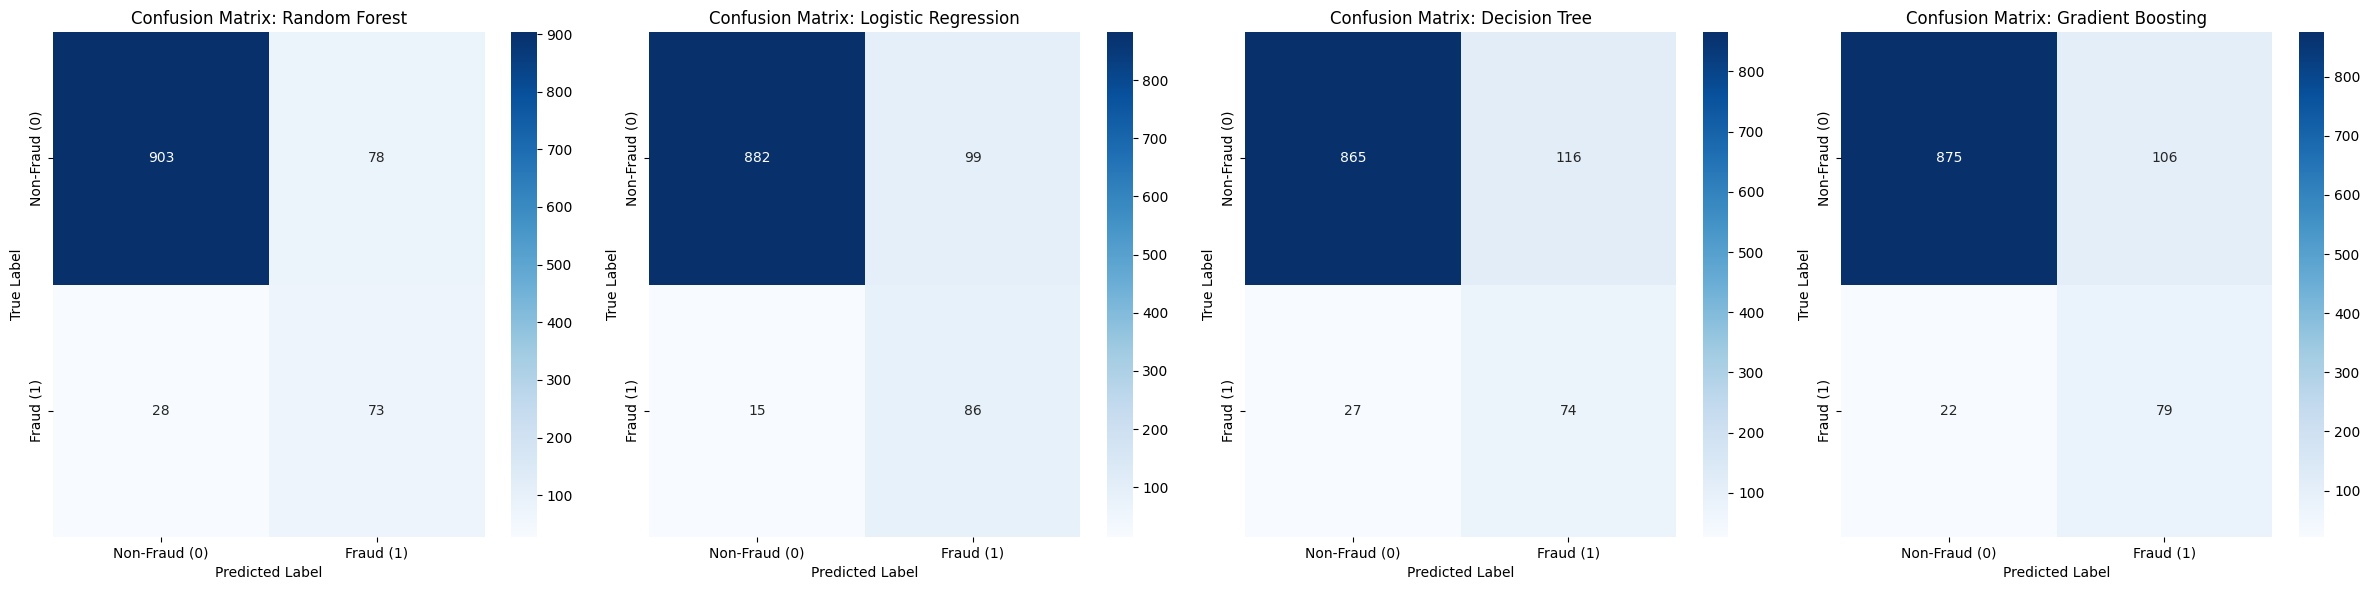

Confusion matrices displayed.


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

print("\n--- Plotting Confusion Matrices (Updated) ---")

def plot_confusion_matrix(y_true, y_pred, model_name, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Fraud (0)', 'Fraud (1)'],
                yticklabels=['Non-Fraud (0)', 'Fraud (1)'], ax=ax)
    ax.set_title(f'Confusion Matrix: {model_name}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

fig, axes = plt.subplots(1, 4, figsize=(24, 6)) # Adjusted for 4 models

plot_confusion_matrix(y_test, y_pred_rf, 'Random Forest', axes[0])
plot_confusion_matrix(y_test, y_pred_lr, 'Logistic Regression', axes[1])
plot_confusion_matrix(y_test, y_pred_dt, 'Decision Tree', axes[2])
plot_confusion_matrix(y_test, y_pred_gbc, 'Gradient Boosting', axes[3]) # New model

plt.tight_layout()
plt.show()
print("Confusion matrices displayed.")


--- Plotting ROC Curves (Updated) ---


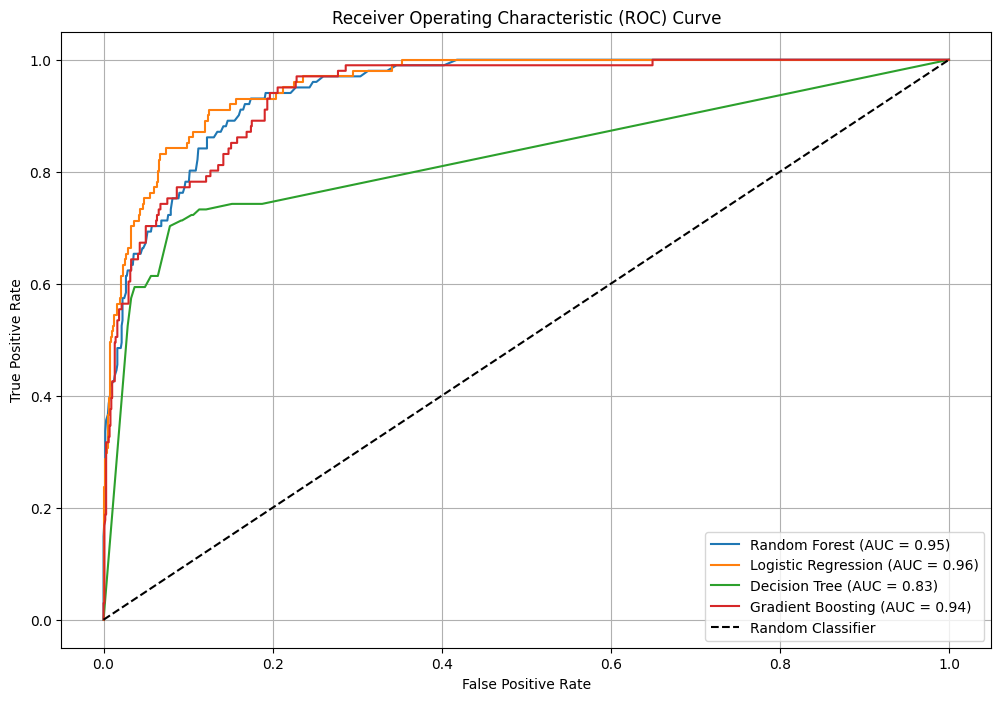

ROC curves displayed.


In [24]:
from sklearn.metrics import roc_curve, roc_auc_score

print("\n--- Plotting ROC Curves (Updated) ---")

plt.figure(figsize=(12, 8)) # Slightly larger figure for more curves

# Plot ROC for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_prob_rf):.2f})')

# Plot ROC for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_prob_lr):.2f})')

# Plot ROC for Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_score(y_test, y_prob_dt):.2f})')

# Plot ROC for Gradient Boosting (New)
fpr_gbc, tpr_gbc, _ = roc_curve(y_test, y_prob_gbc)
plt.plot(fpr_gbc, tpr_gbc, label=f'Gradient Boosting (AUC = {roc_auc_score(y_test, y_prob_gbc):.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier') # Dashed diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
print("ROC curves displayed.")

## Train Final Logistic Regression Model and Save It



In [ ]:
import joblib

print("\n--- Training Final Logistic Regression Model ---")

# Get the best parameters from the GridSearchCV object for Logistic Regression
best_params_lr = grid_search.best_params_

# Initialize the final Logistic Regression model with the best parameters
final_lr_model = LogisticRegression(
    solver='liblinear', # Use the solver that supports l1/l2 penalties
    random_state=42,
    class_weight='balanced',
    **best_params_lr
)

# Train the final model on the entire resampled training data
final_lr_model.fit(X_train_resampled, y_train_resampled)

print("Final Logistic Regression model trained successfully with best parameters.")

# --- Save the Trained Model ---
# Define the path to save the model in the 'data' folder
model_save_path = 'data/final_logistic_regression_model.joblib'

# Save the model using joblib
joblib.dump(final_lr_model, model_save_path)

print(f"Final Logistic Regression model saved to: {model_save_path}")

# --- Optional: Verify the saved model by loading it ---
# loaded_model = joblib.load(model_save_path)
# print(f"Model successfully loaded from disk. Type: {type(loaded_model)}")


--- Training Final Logistic Regression Model ---
Final Logistic Regression model trained successfully with best parameters.
Final Logistic Regression model saved to: data/final_logistic_regression_model.joblib
